# Atlanta Crime - Supervised Learning

## Description
In this part of the project, we will use supervised learning algorithms, namely, Decision Trees, Random Forests, NBC, SVM, and Logistic Regression algorithms to predict crime score for a given location and time.

## Import Packages

In [167]:
import pandas as pd

# from sklearn.tree import plot_tree
# from sklearn.tree.export import export_text
# from sklearn.model_selection import train_test_split # Import train_test_split function

# Preprocessing, Metrics
from sklearn import preprocessing
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# Classifiers, Regressions for DT, RF, NB, SV, LogReg, LinReg
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import BayesianRidge

# from sklearn.svm import SVC
# from sklearn.svm import SVR

from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LinearRegression

# Other imports
import datetime
import random
import numpy as np
import time
import matplotlib.pyplot as plt

## Load in Data

In [168]:
training_categories = pd.read_csv("data/Supervised_Algs/cobra-clean2009.csv", sep=',', header=0, usecols = lambda column : column in ["Occur Date", "Shift Occurrence", "Neighborhood", "Day of Week", "Crime Category"])
# training_categories.head()

training_crime_scores = pd.read_csv("data/Supervised_Algs/bigdaddy.csv", usecols = lambda column : column not in ["Date", "Year", "Day of Month"])
# training_crime_scores.head()

In [169]:
test_categories = pd.read_csv("data/Supervised_Algs/cobra-clean2019.csv", sep=',', header=0, usecols = lambda column : column in ["Occur Date", "Shift Occurrence", "Neighborhood", "Day of Week", "Crime Category"])
# test_categories.head()

test_crime_scores = pd.read_csv("data/Supervised_Algs/cobra-counts2019.csv", usecols = lambda column : column not in ["Date", "Year", "Day of Month"])
# test_crime_scores.head()

### Transforming the data

In [170]:
training_categories['Month'] = training_categories["Occur Date"].str.split("/", n = 1, expand = True)[0]
training_categories = training_categories.drop(["Occur Date"], 1)

le = preprocessing.LabelEncoder()
le.fit(training_categories["Neighborhood"])
training_categories["Neighborhood"] = le.transform(training_categories["Neighborhood"])
le.fit(training_categories["Shift Occurrence"])
training_categories["Shift Occurrence"] = le.transform(training_categories["Shift Occurrence"])

training_categories = training_categories.sample(frac=1)

# training_categories.head()


training_crime_scores['Crime Score'] = 1000 * training_crime_scores['Category 1'] + 100 * training_crime_scores['Category 2'] + 10 * training_crime_scores['Category 3'] + 1 * training_crime_scores['Category 4']
training_crime_scores = training_crime_scores.drop(["Category 1", "Category 2", "Category 3", "Category 4"], 1)

le = preprocessing.LabelEncoder()
le.fit(training_crime_scores["Neighborhood"])
training_crime_scores["Neighborhood"] = le.transform(training_crime_scores["Neighborhood"])
# le.fit(training_crime_scores["Shift"])
# training_crime_scores["Shift"] = le.transform(training_crime_scores["Shift"])

training_crime_scores = training_crime_scores.sample(frac=1)

# training_crime_scores.head()

In [171]:
test_categories['Month'] = test_categories["Occur Date"].str.split("/", n = 1, expand = True)[0]
test_categories = test_categories.drop(["Occur Date"], 1)

le = preprocessing.LabelEncoder()
le.fit(test_categories["Neighborhood"])
test_categories["Neighborhood"] = le.transform(test_categories["Neighborhood"])
le.fit(test_categories["Shift Occurrence"])
test_categories["Shift Occurrence"] = le.transform(test_categories["Shift Occurrence"])

# test_categories.head()


test_crime_scores['Crime Score'] = 1000 * test_crime_scores['Category 1'] + 100 * test_crime_scores['Category 2'] + 10 * test_crime_scores['Category 3'] + 1 * test_crime_scores['Category 4']
test_crime_scores = test_crime_scores.drop(["Category 1", "Category 2", "Category 3", "Category 4"], 1)

le = preprocessing.LabelEncoder()
le.fit(test_crime_scores["Neighborhood"])
test_crime_scores["Neighborhood"] = le.transform(test_crime_scores["Neighborhood"])
# le.fit(test_crime_scores["Shift"])
# test_crime_scores["Shift"] = le.transform(test_crime_scores["Shift"])

# test_crime_scores.head()

## Metrics & Plots

### Splitting data into training and test features and labels: X is features, y is label

In [172]:
# Reading data & split into training and testing sets

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=100)
# Geeksforgeeks: "random_state" variable is a pseudo-random number generator state used for random sampling

# We need the cobra-clean for 2019 to use for the test data
X_train_class = training_categories.drop(['Crime Category'], 1)
y_train_class = training_categories['Crime Category']
X_test_class = test_categories.drop(['Crime Category'], 1)
y_test_class = test_categories['Crime Category']

X_train_reg = training_crime_scores.drop(['Crime Score'], 1)
y_train_reg = training_crime_scores['Crime Score']
X_test_reg = test_crime_scores.drop(['Crime Score'], 1)
y_test_reg = test_crime_scores['Crime Score']

In [173]:
def model_fitting(X_train, y_train, X_test, model, classOrReg):
    start_time = time.time()
    # Model Definition & Fitting
    if model == "dt":
        if classOrReg == "class":
            fitter = DecisionTreeClassifier()
        else:
            fitter = DecisionTreeRegressor()
    elif model == "rf":
        if classOrReg == "class":
            fitter = RandomForestClassifier(n_estimators=100)
        else:
            fitter = RandomForestRegressor(n_estimators=100)
    elif model == "nb":
        if classOrReg == "class":
            fitter = GaussianNB()
        else:
            fitter = BayesianRidge()
#     elif model == "sv":
#         if classOrReg == "class":
#             fitter = SVC(gamma='scale')
#         else:
#             fitter = SVR()
    elif model == "logreg":
        fitter = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000)
    elif model == "linreg":
        fitter = LinearRegression()
    else:
        print("Unrecognized model", model)
        return
    fitter = fitter.fit(X_train, y_train)
    end_time = time.time()
    # Predict based on the given features for the test set
    y_pred = fitter.predict(X_test)
    return (fitter, y_pred, end_time - start_time)

## Cross Validation of Methods

In [126]:
def apr(y_test, y_pred):
    acc_score = metrics.accuracy_score(y_test, y_pred)
    prec_cats_score = metrics.precision_score(y_test, y_pred, average=None)
    recall_cats_score = metrics.recall_score(y_test, y_pred, average=None)
    return acc_score, prec_cats_score, recall_cats_score

In [127]:
def rmse(pred, label):
    return np.sqrt(np.sum(np.square(np.subtract(pred, label))) / len(pred))

In [264]:
def cross_validation(X, y, kfold, model, classOrReg):
    totalTime = 0
    totalAPR = np.array([0, [0, 0, 0, 0], [0, 0, 0, 0]])
    totalRMSE = 0
    for i in range(kfold):
        ind1 = int(i * len(X) / kfold)
        ind2 = int((i + 1) * len(X) / kfold)
        if ind1 == 0:
            trainX = X[ind2:]
            trainY = y[ind2:]
        elif ind2 == len(X):
            trainX = X[:ind1]
            trainY = y[:ind1]
        else:
            trainX = np.concatenate((X[:ind1], X[ind2:]))
            trainY = np.concatenate((y[:ind1], y[ind2:]))
        testX = X[ind1:ind2]
        testY = y[ind1:ind2]
        
        fitter, y_predictor, elapsed_time = model_fitting(trainX, trainY, testX, model, classOrReg)
        totalTime += elapsed_time
        # acc_prec_rec_valid = apr(y_predictor, testY)
        if classOrReg == "class":
            if model == "linreg":
                totalAPR += apr(np.around(y_predictor), testY)
            else:
                totalAPR += apr(y_predictor, testY)
        else:
            totalRMSE += rmse(y_predictor, testY)
    if classOrReg == "class":
        return totalTime / kfold, totalAPR / kfold
    else:
        return totalTime / kfold, totalRMSE / kfold
    raise NotImplementedError

cv_times_class = np.array([])
cv_times_reg = np.array([])
APR_array = np.array([])
RMSE_array = np.array([])
for model in ["dt", "rf", "nb", "linreg"]:
    # print("model: " + model)
    for classOrReg in ["class", "reg"]:
        # print("classOrReg: " + classOrReg)
        if classOrReg == "class":
            avg_time, avg_APR = cross_validation(X_train_class, y_train_class, 10, model, classOrReg)
            # print('average time: %.6f'% avg_time)
            cv_times_class = np.append(cv_times_class, avg_time)
            # print('average APR:', avg_APR)
            APR_array = np.append(APR_array, avg_APR)
        else:
            avg_time, avg_RMSE = cross_validation(X_train_reg, y_train_reg, 10, model, classOrReg)
            # print('average time: %.6f'% avg_time)
            cv_times_reg = np.append(cv_times_reg, avg_time)
            # print('average RMSE:', avg_RMSE)
            RMSE_array = np.append(RMSE_array, avg_RMSE)
        # print()
    # print()

average time: 0.427017
average time: 21.024219


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined an

average time: 0.102993


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined an

average time: 0.092304


In [304]:
plt.figure(figsize=(12, 6))
plt.bar([i - 0.125 for i in range(len(cv_times_class))], cv_times_class, width=0.25, color="gold")
for i in range(len(cv_times_class)):
    plt.text(i - 0.125, cv_times_class[i], round(cv_times_class[i], 2), va='bottom', ha='center')
plt.bar([i + 0.125 for i in range(len(cv_times_reg))], cv_times_reg, width=0.25, color="red")
for i in range(len(cv_times_reg)):
    plt.text(i + 0.125, cv_times_reg[i], round(cv_times_reg[i], 2), va='bottom', ha='center')


plt.xticks([i for i in range(len(cv_times_class))], ["DT", "RF", "NBC", "LinReg"])
plt.legend(["Categories (Classifier)", "Crime Scores (Regressor)"])
plt.xlabel("Supervised Method")
plt.ylabel("Time (seconds)")
plt.title("Average Cross Validation Runtimes of Classification or Regression Methods")

plt.savefig('images/Supervised_Algs/cv_elapsed_times.png')
plt.show()

NameError: name 'cv_times_class' is not defined

<Figure size 864x432 with 0 Axes>

In [301]:
# print(times_class)
# print(times_reg)
# for i, acc_prec_rec in enumerate(APR_array):
#     print(i, acc_prec_rec)
# print(RMSE_array)
tempAPR_array = []
for i in range(int(len(APR_array) / 3)):
    tempAPR_array.append([APR_array[i * 3], APR_array[i * 3 + 1], APR_array[i * 3 + 2]])
# for i in range(len(APR_array) / 3):
#     tempAPR_array = np.append(tempAPR_array)
# tempAPR_array[2]

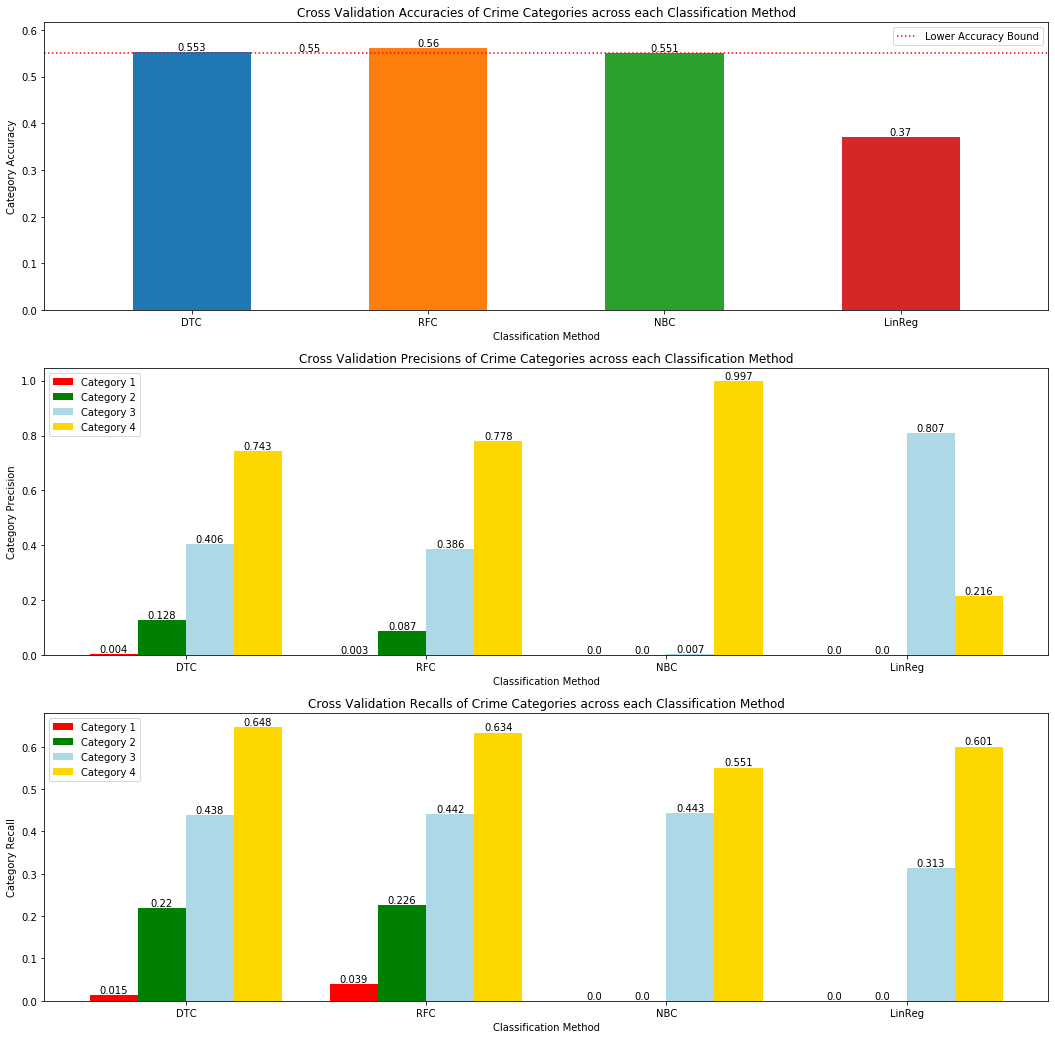

In [303]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(18,18))

# y_preds = [dt_class_y_pred, rf_class_y_pred, nb_class_y_pred, linreg_class_y_pred]
y_preds_colors = ["red", "green", "lightblue", "gold"]

for i, acc_prec_rec in enumerate(tempAPR_array):
    # acc_prec_rec = apr(y_test_class, y_pred)

    ax0.bar(i, acc_prec_rec[0], width=0.5)
    ax0.text(i, acc_prec_rec[0], round(acc_prec_rec[0], 3), va='bottom', ha='center')

    for j in range(len(acc_prec_rec[1])):
        ax1.bar(2.5 * i - 0.75 + 0.5 * j, acc_prec_rec[1][j], width=0.5, color=y_preds_colors[j])
        ax1.text(2.5 * i - 0.75 + 0.5 * j, acc_prec_rec[1][j],
                 round(acc_prec_rec[1][j], 3), va='bottom', ha='center')
        
        ax2.bar(2.5 * i - 0.75 + 0.5 * j, acc_prec_rec[2][j], width=0.5, color=y_preds_colors[j])
        ax2.text(2.5 * i - 0.75 + 0.5 * j, acc_prec_rec[2][j],
                 round(acc_prec_rec[2][j], 3), va='bottom', ha='center')

# Accuracy Plot
plt.sca(ax0)
# plt.legend(["DTC", "RFC", "NBC", "SVC", "LogReg", "LinReg"])
classNames = ["DTC", "RFC", "NBC", "LinReg"]
plt.xticks([j for j in range(len(classNames))], classNames)

max_acc = 0
for i in range(1, 5):
    max_acc = max(max_acc, len(training_categories[training_categories["Crime Category"] == i]) / len(training_categories))

plt.plot([0 - 0.625, len(classNames) - 1 + 0.625], [max_acc, max_acc], ':r')
plt.text(0.5, max_acc, str(round(max_acc, 3)), va='bottom', ha='center')
plt.margins(x=0, y=0.1, tight=True)
plt.legend(["Lower Accuracy Bound"])
plt.xlabel("Classification Method")
plt.ylabel("Category Accuracy")
plt.title("Cross Validation Accuracies of Crime Categories across each Classification Method")

# Precision Plot
plt.sca(ax1)
plt.legend(["Category 1", "Category 2", "Category 3", "Category 4"])
plt.xticks([j * 2.5 for j in range(len(classNames))], classNames)
plt.xlabel("Classification Method")
plt.ylabel("Category Precision")
plt.title("Cross Validation Precisions of Crime Categories across each Classification Method")

# Recall Plot
plt.sca(ax2)
plt.legend(["Category 1", "Category 2", "Category 3", "Category 4"])
plt.xticks([j * 2.5 for j in range(len(classNames))], classNames)
plt.xlabel("Classification Method")
plt.ylabel("Category Recall")
plt.title("Cross Validation Recalls of Crime Categories across each Classification Method")

plt.savefig('images/Supervised_Algs/cv_apr_categories.png')
plt.show()

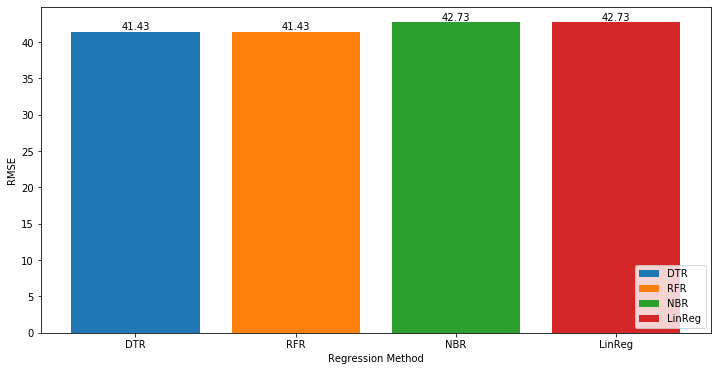

In [295]:
plt.figure(figsize=(12, 6))
for i, rmse_val in enumerate(RMSE_array):
    # rmse_val = rmse(y_test_reg, y_pred)
    plt.bar(i, rmse_val)
    plt.text(i, rmse_val, round(rmse_val, 2), va='bottom', ha='center')

regNames = ["DTR", "RFR", "NBR", "LinReg"]
plt.legend(regNames, loc='lower right')
plt.xticks([j for j in range(len(regNames))], regNames)
plt.xlabel("Regression Method")
plt.ylabel("RMSE")

plt.savefig('images/Supervised_Algs/cv_rmse.png')
plt.show()

## Models, Definition & Fitting

### Decision Tree Models

In [174]:
# Category classification
dt_class_fit, dt_class_y_pred, dt_class_elapsed_time = model_fitting(X_train_class, y_train_class, X_test_class, "dt", "class")

In [175]:
# Crime score regression
dt_reg_fit, dt_reg_y_pred, dt_reg_elapsed_time = model_fitting(X_train_reg, y_train_reg, X_test_reg, "dt", "regress")

### Random Forest Models

In [176]:
# Category classification
rf_class_clf, rf_class_y_pred, rf_class_elapsed_time = model_fitting(X_train_class, y_train_class, X_test_class, "rf", "class")

In [177]:
rf_reg_clf, rf_reg_y_pred, rf_reg_elapsed_time = model_fitting(X_train_reg, y_train_reg, X_test_reg, "rf", "regress")

### NBC Models

In [178]:
# Category classification
nb_class_clf, nb_class_y_pred, nb_class_elapsed_time = model_fitting(X_train_class, y_train_class, X_test_class, "nb", "class")

In [179]:
nb_reg_clf, nb_reg_y_pred, nb_reg_elapsed_time = model_fitting(X_train_reg, y_train_reg, X_test_reg, "nb", "regress")

### Logistic Regressions

In [39]:
logreg_class_clf, logreg_class_y_pred, logreg_class_elapsed_time = model_fitting(X_train_class, y_train_class, X_test_class, "logreg", "class")

In [40]:
logreg_reg_clf, logreg_reg_y_pred, logreg_reg_elapsed_time = model_fitting(X_train_reg, y_train_reg, X_test_reg, "logreg", "regress")

KeyboardInterrupt: 

### Linear Regressions

In [180]:
# IGNORE: Category classification
linreg_class_clf, linreg_class_y_pred, linreg_class_elapsed_time = model_fitting(X_train_class, y_train_class, X_test_class, "linreg", "class")
linreg_class_y_pred = np.around(linreg_class_y_pred)

In [181]:
# Crime score classification
linreg_reg_clf, linreg_reg_y_pred, linreg_reg_elapsed_time = model_fitting(X_train_reg, y_train_reg, X_test_reg, "linreg", "regress")

## Plots

### Time Plot

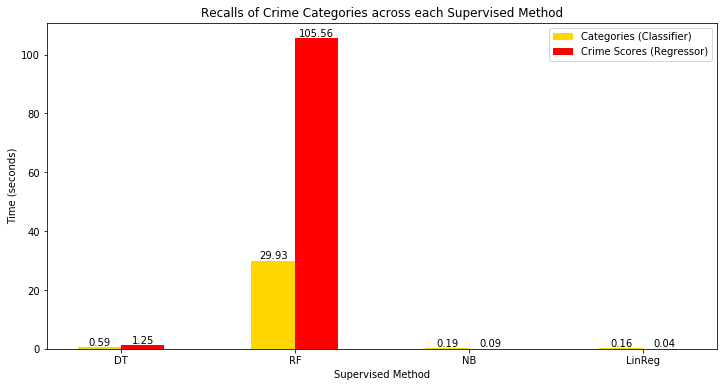

In [305]:
times_class = np.array([dt_class_elapsed_time, rf_class_elapsed_time, nb_class_elapsed_time, linreg_class_elapsed_time])
times_reg = np.array([dt_reg_elapsed_time, rf_reg_elapsed_time, nb_reg_elapsed_time, linreg_reg_elapsed_time])

plt.figure(figsize=(12, 6))
plt.bar([i - 0.125 for i in range(len(times_class))], times_class, width=0.25, color="gold")
for i in range(len(times_class)):
    plt.text(i - 0.125, times_class[i], round(times_class[i], 2), va='bottom', ha='center')
plt.bar([i + 0.125 for i in range(len(times_reg))], times_reg, width=0.25, color="red")
for i in range(len(times_reg)):
    plt.text(i + 0.125, times_reg[i], round(times_reg[i], 2), va='bottom', ha='center')


plt.xticks([i for i in range(len(times_class))], ["DT", "RF", "NB", "LinReg"])
plt.legend(["Categories (Classifier)", "Crime Scores (Regressor)"])
plt.xlabel("Supervised Method")
plt.ylabel("Time (seconds)")
plt.title("Recalls of Crime Categories across each Supervised Method")

plt.savefig('images/Supervised_Algs/elapsed_times.png')
plt.show()

### Accuracy, Precision, Recall Plots of Classification

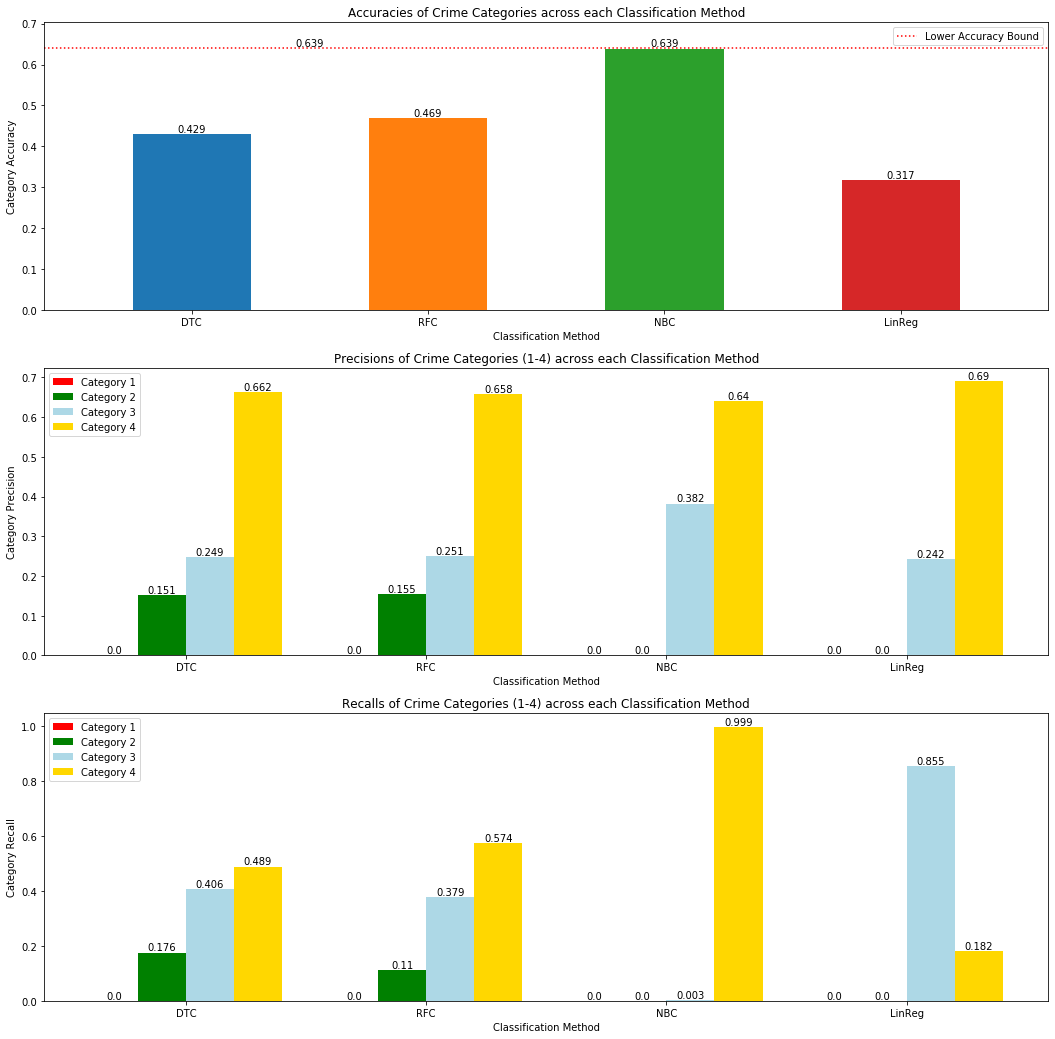

In [299]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(18,18))

y_preds = [dt_class_y_pred, rf_class_y_pred, nb_class_y_pred, linreg_class_y_pred]
y_preds_colors = ["red", "green", "lightblue", "gold"]

for i, y_pred in enumerate(y_preds):
    acc_prec_rec = apr(y_test_class, y_pred)

    ax0.bar(i, acc_prec_rec[0], width=0.5)
    ax0.text(i, acc_prec_rec[0], round(acc_prec_rec[0], 3), va='bottom', ha='center')

    for j in range(len(acc_prec_rec[1])):
        ax1.bar(2.5 * i - 0.75 + 0.5 * j, acc_prec_rec[1][j], width=0.5, color=y_preds_colors[j])
        ax1.text(2.5 * i - 0.75 + 0.5 * j, acc_prec_rec[1][j],
                 round(acc_prec_rec[1][j], 3), va='bottom', ha='center')
        
        ax2.bar(2.5 * i - 0.75 + 0.5 * j, acc_prec_rec[2][j], width=0.5, color=y_preds_colors[j])
        ax2.text(2.5 * i - 0.75 + 0.5 * j, acc_prec_rec[2][j],
                 round(acc_prec_rec[2][j], 3), va='bottom', ha='center')

# Accuracy Plot
plt.sca(ax0)
# plt.legend(["DTC", "RFC", "NBC", "SVC", "LogReg", "LinReg"])
classNames = ["DTC", "RFC", "NBC", "LinReg"]
plt.xticks([j for j in range(len(classNames))], classNames)

max_acc = 0
for i in range(1, 5):
    max_acc = max(max_acc, len(test_categories[test_categories["Crime Category"] == i]) / len(test_categories))

plt.plot([0 - 0.625, len(classNames) - 1 + 0.625], [max_acc, max_acc], ':r')
plt.text(0.5, max_acc, str(round(max_acc, 3)), va='bottom', ha='center')
plt.margins(x=0, y=0.1, tight=True)
plt.legend(["Lower Accuracy Bound"])
plt.xlabel("Classification Method")
plt.ylabel("Category Accuracy")
plt.title("Accuracies of Crime Categories |across each Classification Method")

# Precision Plot
plt.sca(ax1)
plt.legend(["Category 1", "Category 2", "Category 3", "Category 4"])
plt.xticks([j * 2.5 for j in range(len(classNames))], classNames)
plt.xlabel("Classification Method")
plt.ylabel("Category Precision")
plt.title("Precisions of Crime Categories across each Classification Method")

# Recall Plot
plt.sca(ax2)
plt.legend(["Category 1", "Category 2", "Category 3", "Category 4"])
plt.xticks([j * 2.5 for j in range(len(classNames))], classNames)
plt.xlabel("Classification Method")
plt.ylabel("Category Recall")
plt.title("Recalls of Crime Categories across each Classification Method")

plt.savefig('images/Supervised_Algs/apr_categories.png')
plt.show()

### RMSE of Regression

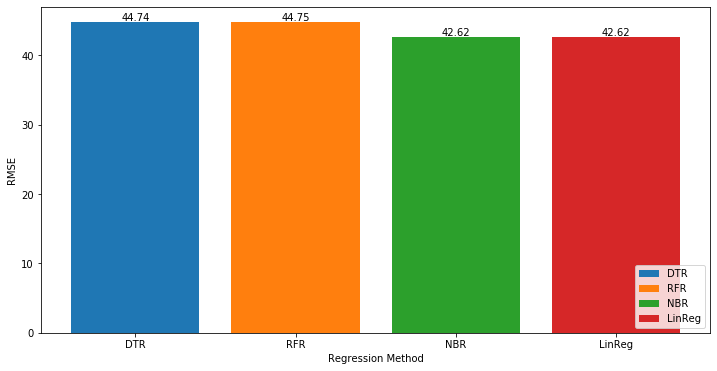

In [306]:
plt.figure(figsize=(12, 6))
for i, y_pred in enumerate([dt_reg_y_pred, rf_reg_y_pred, nb_reg_y_pred, linreg_reg_y_pred]):
    rmse_val = rmse(y_test_reg, y_pred)
    plt.bar(i, rmse_val)
    plt.text(i, rmse_val, round(rmse_val, 2), va='bottom', ha='center')

regNames = ["DTR", "RFR", "NBR", "LinReg"]
plt.legend(regNames, loc='lower right')
plt.xticks([j for j in range(len(regNames))], regNames)
plt.xlabel("Regression Method")
plt.ylabel("RMSE")

plt.savefig('images/Supervised_Algs/rmse.png')
plt.show()

## Other stuff

In [26]:
print(len(training_categories[training_categories["Crime Category"] == 1]) / len(training_categories))
print(len(training_categories[training_categories["Crime Category"] == 2]) / len(training_categories))
print(len(training_categories[training_categories["Crime Category"] == 3]) / len(training_categories))
print(len(training_categories[training_categories["Crime Category"] == 4]) / len(training_categories))

print(max(training_crime_scores["Crime Score"]))
print(max(test_crime_scores["Crime Score"]))

0.002731061246896914
0.13589014988036502
0.3110889373029821
0.550289851569756
5824
3494


In [118]:
data = pd.read_csv("data/Supervised_Algs/cobra-counts2019.csv", usecols = lambda column : column in ["Neighborhood", "Category 1", "Category 2", "Category 3", "Category 4"])

# data[["Category 1", "Category 2", "Category 3", "Category 4"]].sum(axis=0)

newData = []
for e in pd.unique(data["Neighborhood"]):
    cat_counts = data[data["Neighborhood"] == e][["Category 1", "Category 2", "Category 3", "Category 4"]].sum(axis=0)
    newData.append([e, cat_counts["Category 1"], cat_counts["Category 2"], cat_counts["Category 3"], cat_counts["Category 4"]])

df = pd.DataFrame(newData, columns=["Neighborhood", "Category 1", "Category 2", "Category 3", "Category 4"])
df['Crime Score'] = 1000 * df['Category 1'] + 100 * df['Category 2'] + 10 * data['Category 3'] + 1 * df['Category 4']

df = df.drop(["Category 1", "Category 2", "Category 3", "Category 4"], 1)

df.head()

,Neighborhood,Crime Score
0,Downtown,23254.0
1,Greenbriar,4742.0
2,Wildwood (NPU-C),1376.0
3,Lindbergh/Morosgo,3514.0
4,Grant Park,4016.0


In [250]:
# apr(y_test_class, nb_class_y_pred)

# a, b, c = model_fitting(X_train_class, y_train_class, X_test_class, "nb", "class")

# newData = []
# for e in pd.unique(X_test_class["Neighborhood"]):
#     cat_counts = X_test_class[X_test_class["Neighborhood"] == e][["Category 1", "Category 2", "Category 3", "Category 4"]].sum(axis=0)
#     newData.append([e, cat_counts["Category 1"], cat_counts["Category 2"], cat_counts["Category 3"], cat_counts["Category 4"]])

data2 = pd.read_csv("data/Supervised_Algs/cobra-counts2019.csv", usecols = lambda column : column not in ["Date", "Year", "Day of Month"])
# data2['Crime Score'] = 1000 * data2['Category 1'] + 100 * data2['Category 2'] + 10 * data2['Category 3'] + 1 * data2['Category 4']
data2 = data2.drop(["Category 1", "Category 2", "Category 3", "Category 4", "Month", "Day of Week"], 1)
# print(data2)
# list(le.inverse_transform(le.transform(data2["Neighborhood"])))
# data2

# data2["Neighborhood"] = le.transform(data2["Neighborhood"])
# data2.head()

# newData2 = []
# for e in pd.unique(data2["Neighborhood"]):
#     cat_counts = data2[data2["Neighborhood"] == e][["Category 1", "Category 2", "Category 3", "Category 4"]].sum(axis=0)
#     newData2.append([e, cat_counts["Category 1"], cat_counts["Category 2"], cat_counts["Category 3"], cat_counts["Category 4"]])

# df2 = pd.DataFrame(newData2, columns=["Neighborhood", "Category 1", "Category 2", "Category 3", "Category 4"])
# df2.head()
# list(le.classes_)
# le = preprocessing.LabelEncoder()
# le.fit(data2["Neighborhood"])
# data2["Neighborhood"] = le.transform(data2["Neighborhood"])
# data2.head()

# a, b, c = model_fitting(X_train_reg, y_train_reg, X_test_reg, "nb", "class")
# print(np.sum(b))
# rmse(y_test_reg, b)
data2["Crime Score"] = nb_reg_y_pred
newData2 = []
for e in pd.unique(data2["Neighborhood"]):
    cs_counts = data2[data2["Neighborhood"] == e][["Crime Score"]].sum(axis=0)
    newData2.append([e, cs_counts["Crime Score"]])
# data2
df2 = pd.DataFrame(newData2, columns=["Neighborhood", "Crime Score"])
df2.to_csv("data/Supervised_Algs/visualize_predicted_scores.csv", index=False)